# Create Custom Metrics via GraphQL

## Step 1: Initialize the GraphQL Client using your developer API Key

In [ ]:
!pip install -q gql[all]
from gql import Client, gql
from gql.transport.requests import RequestsHTTPTransport

### Get your API key
First, make sure you have developer permissions. If you are able to visit the [API explorer](https://app.arize.com/graphql), then you have developer permissions. If not, please ask your Account Admin to provide you with access. 

The API key can be retrieved from the [API explorer](https://app.arize.com/graphql) page. Click the button on the top right called "Get Your API Key." A modal will pop up with your key, copy that into the `API_KEY` constant below. 

NOTE: this key is different than the SDK key used to send data to Arize.

In [ ]:
# Initialize GraphQL clients with your GraphQL specific API_KEY - retrieve this in API Explorer
API_KEY = "API_KEY"  # TODO: set your API_KEY

# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(
    url="https://app.arize.com/graphql/", headers={"x-api-key": API_KEY}
)

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

## Step 2: Get All Model IDs by Executing a GraphQL Query

In [ ]:
# We start this query from your space. Spaces have globally unique IDs. You can get your space ID by visiting app.arize.com.
# The url will be in this format: https://app.arize.com/organizations/:orgId/spaces/:spaceId
# NOTE: this is not the same as the space key used to send data using the SDK
SPACE_ID = "SPACE_ID"  # TODO: set your SPACE_ID

In [ ]:
# A re-usable query for fetching your models, a page at a time
models_query = gql(
    """
    query getModels($spaceId: ID!, $cursor: String) {
        space: node(id: $spaceId) {
            ... on Space {
                name
                models (first: 50, after: $cursor) {
                    pageInfo {
                        endCursor
                    }
                    edges {
                        model: node {
                            id
                            name
                        }
                    }
                }
            }
        }
    }
"""
)

# Base query parameters for fetching models
params = {"spaceId": SPACE_ID}
# An array of models that we will append to
models = []
space_name = ""

# Execute the query on the transport. Continue to pull data until there is no more monitors
print("Retrieving models...")
while True:
    paged_response = client.execute(models_query, params)
    space_name = paged_response["space"]["name"]
    # Append the monitors to your list
    models.extend(paged_response["space"]["models"]["edges"])
    # If there is another page of information, point the cursor to the next page and fetch more
    end_cursor = paged_response["space"]["models"]["pageInfo"]["endCursor"]
    print("pageInfo end_cursor %s" % (end_cursor))
    if end_cursor:
        print("There is another page of models. Loading more.")
        params["cursor"] = end_cursor
    else:
        # No more models to pull. The list is complete!
        break

print("\nRetrieved {} models:".format(len(models)))

We can see the list of models and model IDs that we retrieved using GraphQL:

In [ ]:
import pandas as pd

models_df = pd.json_normalize(models, sep=".")
models_df.head()

We will save these model IDs in a Google Sheet:

In [ ]:
# authorize to Google Sheets
!pip install -q gspread
# src: https://colab.research.google.com/notebooks/snippets/sheets.ipynb
from google.colab import auth

auth.authenticate_user()

import gspread
from gspread_dataframe import set_with_dataframe
from google.auth import default

creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
# create and populate Google Sheet
sheet_name = f"Space: '{space_name}' - Custom Metrics Worksheet"
sh = gc.create(sheet_name)

worksheet = gc.open(sheet_name).sheet1
worksheet.update_title("Model IDs")
set_with_dataframe(
    worksheet=worksheet,
    dataframe=models_df,
    include_index=False,
    include_column_header=True,
)

print(f"Created Google sheet: {sh.url}")

## Step 3: Add Custom Metrics

### Step 3a. Create page in Google Sheet, and add custom metrics

For the purpose of this Colab, we will define our custom metrics in a Google Sheet for nicer visualization. The custom metrics defined in sheets will then be reimported and applied using GraphQL. 

**Note:** The creation of a spreadsheet as an intermediate step is NOT required for adding new custom metrics via GraphQL. This is solely for ease of editing and visual representation in this demo.

In [ ]:
from datetime import datetime

# Run this cell only once to create a new page in the spreadsheet, this is where we will add custom metrics

custom_metric_params = ["modelId", "name", "description", "metric"]

currentTime = datetime.now().strftime("%H:%M:%S")
create_worksheet_name = f"Populate New Custom Metrics - {currentTime}"

sh.add_worksheet(title=create_worksheet_name, rows="1000", cols="20")
worksheet = sh.worksheet(create_worksheet_name)
worksheet.update([custom_metric_params])

print(f"Go to '{create_worksheet_name}' page: {sh.url}")

#### Add custom metrics

Once you run the cell above, you will find a new page pop up in your spreadsheet with ONLY headings.

This is where you will define your new custom metrics. Go ahead and add each custom metric into your spreadsheet page.

**Columns:**

**\*** Required fields

Column  | Description
-------------------|------------------
`modelId*`       | Fill in the modelId for the model you'd like to add this custom metric to. Refer to the "Model IDs" page of the spreadsheet to get the ID of the model.
`name*`       | Name to give your custom metric.
`description*` | Name to give your custom metric.
`metric*`| Your metric as you would define it in platform using [Custom Metric Syntax](https://docs.arize.com/arize/api-reference/12.-custom-metrics/custom-metric-syntax).

Once filled in, your sheet should look something like the image below:

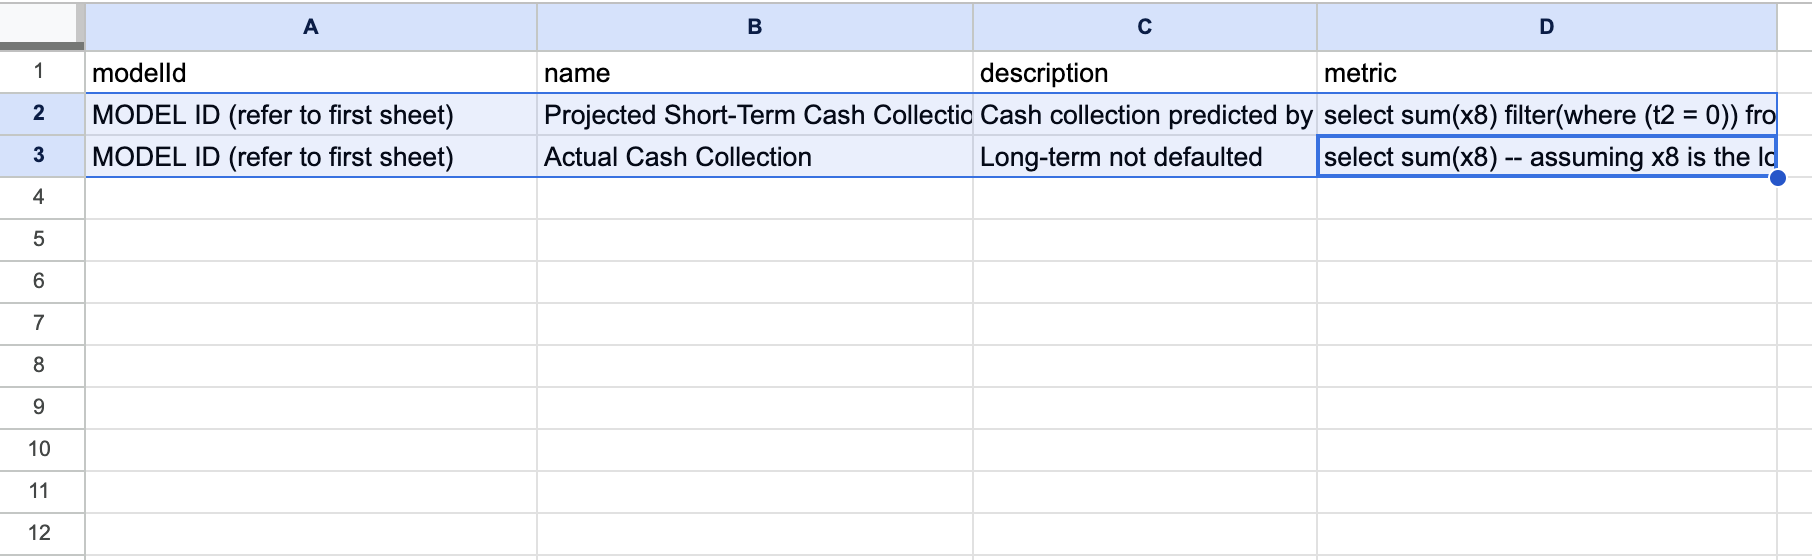

### Step 3b. Import data from Sheets, and issue GraphQL mutation to create the Custom Metrics

In [ ]:
# ingest entries from Google Sheets back into a pandas dataframe to be parsed for GraphQL payloads
print(
    f"Retrieving custom metrics to add from Google Sheet page: '{create_worksheet_name}'"
)
worksheet = sh.worksheet(create_worksheet_name)
custom_monitors_df = pd.DataFrame(worksheet.get_all_records())

# print this dataframe to ensure that it includes all of the entries that you expect
custom_monitors_df.head()

In [ ]:
# define custom metrics mutation
create_custom_metrics_mutation = gql("""
  mutation createCustomMetricMutation(
    $modelId: ID!,
    $name: String!,
    $description: String!,
    $metric: String!
  ) {
    createCustomMetric(
      input: {
        modelId: $modelId,
        name: $name,
        description: $description,
        metric: $metric
      }
    ) {
      customMetric { id, name, createdAt, metric }
    }
  }
""")

The code block below will create a new custom metric from the data from each row of the spreadsheet.

**Note:**
We will skip any custom metric creation for any rows that have missing values (i.e. all fields are required to be filled in).

In [ ]:
for i, row in custom_monitors_df.iterrows():
    custom_metric_args = {}
    skip_metric = False
    for param in custom_metric_params:
        if not row[param]:
            print(
                f"ERROR: missing '{param}' value for row {i}. skipping creating custom metric for row."
            )
            skip_metric = True
            break

        custom_metric_args[param] = row[param]
    if not skip_metric:
        result = client.execute(
            create_custom_metrics_mutation,
            custom_metric_args,
            serialize_variables=True,
        )
        print(
            f"created custom metric from row {i+1}: {result['createCustomMetric']['customMetric']}"
        )

**Troubleshooting:**
If a metric you wish to create is skipped, please go back and re-run the notebook from step 3a. This will create a NEW page in the Google Sheet. Populate the metric that was skipped in this new page and ensure that all fields are populated. Then run the rest of the notebook to add the custom metric via GraphQL.